In [19]:
!pip install catboost

In [20]:
!pip install pytorch-tabnet

In [21]:
# General libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Skleran modules
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler #check if we really need it
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import KFold

# Tensorflow modules
from tensorflow.keras.models import Model, Sequential
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

# Tabnet import
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetRegressor
import torch


from catboost import CatBoostRegressor

In [22]:
# Common variables
RANDOM_SEED = 42
VAL_SIZE = 0.15 # the size of a validation sample
np.random.seed(RANDOM_SEED)

In [23]:
# Common functions

# A target metric function
def mape(y_true, y_pred):    
    return np.mean(np.abs((y_pred-y_true)/y_true))

# A function for distribution visualisation
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 5, rows * 3))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

In [24]:
df = pd.read_csv('land_lots_eda_available.csv')

In [25]:
df.status.value_counts()

3    359
Name: status, dtype: int64

In [26]:
df.koatuuLocation.values

array(['Іванків, Іванківська, Вишгородський, Київська, Україна',
       'Іванківська, Вишгородський, Київська, Україна',
       'Подо-Калинівка, Ювілейна, Херсонський, Херсонська, Україна',
       'Щасливе, Ювілейна, Херсонський, Херсонська, Україна',
       'Зеленопідська, Каховський, Херсонська, Україна',
       'Урожайне, Бериславська, Бериславський, Херсонська, Україна',
       'Урожайне, Бериславська, Бериславський, Херсонська, Україна',
       'Раківка, Бериславська, Бериславський, Херсонська, Україна',
       'Тягинська, Бериславський, Херсонська, Україна',
       'Демидівка, Демидівська, Дубенський, Рівненська, Україна',
       'Рудка, Демидівська, Дубенський, Рівненська, Україна',
       'Мар’їнська, Покровський, Донецька, Україна',
       'Придніпровське, Червоногригорівська, Нікопольський, Дніпропетровська, Україна',
       'Верхня Ланна, Ланнівська, Полтавський, Полтавська, Україна',
       'Тягинська, Бериславський, Херсонська, Україна',
       'Тягинська, Бериславський, Х

In [27]:
df.head()

,id,status,price,pricePerOne,estimatePrice,rentRate,rentalYield,purpose,koatuuLocation,ownerEdrpou,...,renterEdrpou,isAvailable,region_id,estimateMonth,estimateDay,estimateYear,daysDelta,daysRentPayDelta,daysRentPayDeltaSign,area_win
0,740,3,120000,61137,42477,3812,2.6,1,"Іванків, Іванківська, Вишгородський, Київська,...",3578305088,...,41102844,True,3222055100,12,28,2021,68,-66,0,1.9628
1,739,3,60000,53893,5917,967,1.3,1,"Іванківська, Вишгородський, Київська, Україна",3578305088,...,41102844,True,3222086800,12,28,2021,68,-66,0,1.1133
2,737,3,680000,67156,204989,21120,2.5,1,"Подо-Калинівка, Ювілейна, Херсонський, Херсонс...",2284411333,...,41101589,True,6525082500,9,13,2021,174,-66,0,10.1256
3,736,3,385000,67444,142833,22995,4.8,1,"Щасливе, Ювілейна, Херсонський, Херсонська, Ук...",2520006184,...,41101589,True,6525085600,9,13,2021,174,-66,0,5.7084
4,735,3,400000,56441,187952,22424,4.5,1,"Зеленопідська, Каховський, Херсонська, Україна",2762921072,...,41101589,True,6523584000,12,9,2021,87,299,1,7.0870


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    359 non-null    int64  
 1   status                359 non-null    int64  
 2   price                 359 non-null    int64  
 3   pricePerOne           359 non-null    int64  
 4   estimatePrice         359 non-null    int64  
 5   rentRate              359 non-null    int64  
 6   rentalYield           359 non-null    float64
 7   purpose               359 non-null    int64  
 8   koatuuLocation        359 non-null    object 
 9   ownerEdrpou           359 non-null    int64  
 10  renterCompany         359 non-null    float64
 11  renterEdrpou          359 non-null    int64  
 12  isAvailable           359 non-null    bool   
 13  region_id             359 non-null    int64  
 14  estimateMonth         359 non-null    int64  
 15  estimateDay           3

In [29]:
df.renterEdrpou.value_counts()

41101589    115
34264631     61
41104731     51
41105190     34
41102163     26
41107067     25
41103827     24
41102844     12
41099127      5
41104967      3
41481188      3
Name: renterEdrpou, dtype: int64

In [30]:
df.renterEdrpou.value_counts()

41101589    115
34264631     61
41104731     51
41105190     34
41102163     26
41107067     25
41103827     24
41102844     12
41099127      5
41104967      3
41481188      3
Name: renterEdrpou, dtype: int64

In [31]:
# Getting rid of the id feature
df.drop(['id'], axis = 1, inplace = True)

In [32]:
# Also, because the total price of the lot heavily depends on the area of the lot maybe it makes sense to 
# set the target variable to pricePerOne, not actually price

#### Let's now try to split features into numerical and categorical

In [33]:
df['area_win'].value_counts()

10.2760    26
2.0000     13
0.1575      5
0.4366      3
1.0000      3
           ..
0.3663      1
3.3102      1
0.3656      1
4.1333      1
1.1133      1
Name: area_win, Length: 308, dtype: int64

In [34]:
#Numerical columns
num_col = ['pricePerOne', 'estimatePrice', 'rentalYield', 'daysDelta', 'daysRentPayDelta', 'area_win', 'price']

In [35]:
#Categorical columns
cat_col = ['status', 'region_id', 'rentRate', 'purpose', 'koatuuLocation', 'ownerEdrpou', 'renterCompany', 'isAvailable', 'estimateMonth', 'estimateDay', 'estimateYear', 'daysRentPayDeltaSign']

In [36]:
# Setting target variable
y = df['price']

## Data Processing

#### Let's first figure out the correlation between numeric variables including target ones

In [37]:
df[num_col].corr()

,pricePerOne,estimatePrice,rentalYield,daysDelta,daysRentPayDelta,area_win,price
pricePerOne,1.000000,0.001515,-0.339008,0.297909,0.027341,-0.080137,0.257846
estimatePrice,0.001515,1.000000,-0.003954,0.125492,0.119987,0.153728,0.140434
rentalYield,-0.339008,-0.003954,1.000000,-0.151742,0.068028,0.115887,-0.018683
daysDelta,0.297909,0.125492,-0.151742,1.000000,-0.128190,-0.097450,0.015732
daysRentPayDelta,0.027341,0.119987,0.068028,-0.128190,1.000000,0.098030,0.096097
area_win,-0.080137,0.153728,0.115887,-0.097450,0.098030,1.000000,0.878185
price,0.257846,0.140434,-0.018683,0.015732,0.096097,0.878185,1.000000


#### Let's visualize correlations better with Seaborn

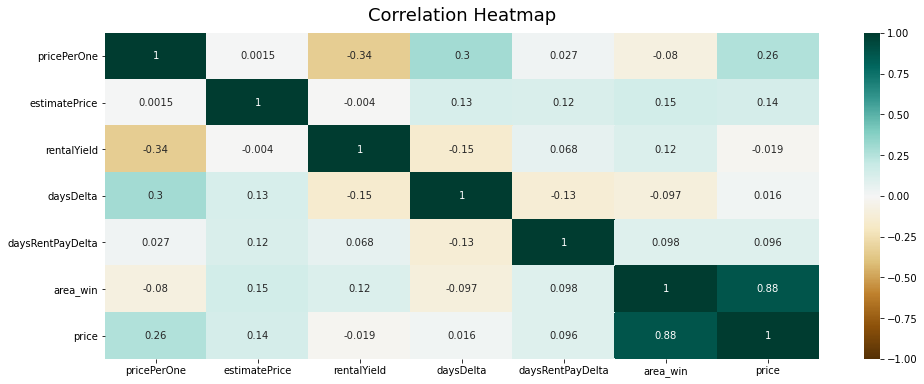

In [38]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[num_col].corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);
# save heatmap as .png file
# dpi - sets the resolution of the saved image in dots/inches
# bbox_inches - when set to 'tight' - does not allow the labels to be cropped
plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

As we can see - there is a very high correlation between the price and are_win. So, I suggest to take a pricePerOne (price per one hectare) as a target variable and remove the **price** feature

In [39]:
y = df['pricePerOne']

In [40]:
# Removing price and pricePerOne from numerical features list
spare_elem = {'pricePerOne', 'price'} 
num_col = [elem for elem in num_col if elem not in spare_elem]

In [41]:
num_col

['estimatePrice', 'rentalYield', 'daysDelta', 'daysRentPayDelta', 'area_win']

## Model 0: Default model
Let's try to build a default naive model based on only on the lot location. Later we will compare our results with this default model

In [42]:
# Splitting data
data_train, data_test = train_test_split(df, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [43]:
# Default model
predicts = []

for index, row in pd.DataFrame(data_test[['koatuuLocation']]).iterrows():
    query = f"koatuuLocation == '{row[0]}'"    
    
    #Because the total price of the lot depends heavily on the area of the lot, we will take price per 1 unit as a target
    predicts.append(data_train.query(query)['pricePerOne'].median())    

predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# Rounding
predicts = (predicts // 1000) * 1000

# Evaluating precision
print(f"The precision of the default model based on MAPE metric is: {(mape(data_test['pricePerOne'], predicts.values[:, 0]))*100:0.2f}%")

The precision of the default model based on MAPE metric is: 34.29%


## Data Analysis

Let's analyze the numerical data first

In [44]:
df[num_col].head()

,estimatePrice,rentalYield,daysDelta,daysRentPayDelta,area_win
0,42477,2.6,68,-66,1.9628
1,5917,1.3,68,-66,1.1133
2,204989,2.5,174,-66,10.1256
3,142833,4.8,174,-66,5.7084
4,187952,4.5,87,299,7.0870


As we can see the scales of our numerical values are quite different. Let's apply Standard Scaler to them

In [45]:
scaled_features = MinMaxScaler().fit_transform(df[num_col].values)

In [46]:
df_num = pd.DataFrame(scaled_features, index=df[num_col].index, columns=df[num_col].columns)

In [47]:
df_num.head()

,estimatePrice,rentalYield,daysDelta,daysRentPayDelta,area_win
0,0.004500,0.320000,0.000000,0.237748,0.178416
1,0.000617,0.146667,0.000000,0.237748,0.094461
2,0.021761,0.306667,0.097070,0.237748,0.985136
3,0.015160,0.613333,0.097070,0.237748,0.548589
4,0.019952,0.573333,0.017399,0.428050,0.684835


Let's see how the distribution on the numerical features look like after Standartization

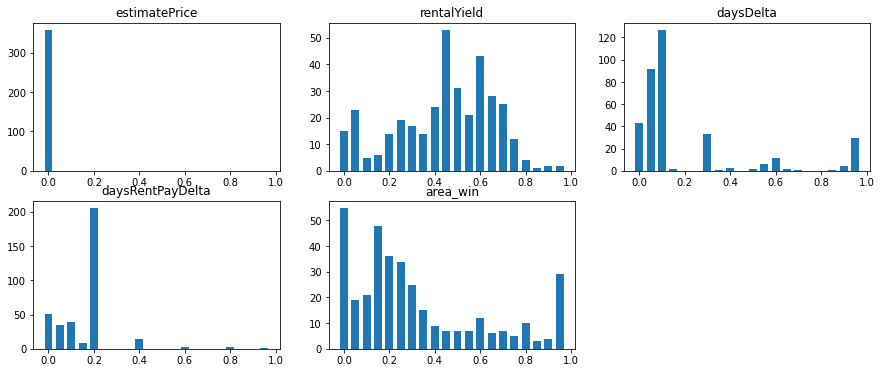

In [48]:
visualize_distributions({
    'estimatePrice': df_num['estimatePrice'],
    'rentalYield': df_num['rentalYield'],
    'daysDelta': df_num['daysDelta'],
    'daysRentPayDelta': df_num['daysRentPayDelta'],
    'area_win': df_num['area_win']        
})

As we can see only **rentalYield** feature has a distribution which is close to normal. All the other features have different distributions, especially strange one is **estimatePrice**. Let's see how their distributions will look like after applying Logarithmization

In [49]:
df_num2 = df_num[['estimatePrice', 'daysDelta', 'daysRentPayDelta', 'area_win']]

In [50]:
# Applying logarithmization to the numerical features, to also avoid errors in case the value is 0
df_num2['estimatePrice'] = df_num2['estimatePrice'].apply(lambda x: x if x == 0 else np.log(x))
df_num2['daysDelta'] = df_num2['daysDelta'].apply(lambda x: x if x == 0 else np.log(x))
df_num2['daysRentPayDelta'] = df_num2['daysRentPayDelta'].apply(lambda x: x if x == 0 else np.log(x))
df_num2['area_win'] = df_num2['area_win'].apply(lambda x: x if x == 0 else np.log(x))

<ipython-input-50-f2878212d206>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num2['estimatePrice'] = df_num2['estimatePrice'].apply(lambda x: x if x == 0 else np.log(x))
<ipython-input-50-f2878212d206>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_num2['daysDelta'] = df_num2['daysDelta'].apply(lambda x: x if x == 0 else np.log(x))
<ipython-input-50-f2878212d206>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

In [51]:
df_num2.head()

,estimatePrice,daysDelta,daysRentPayDelta,area_win
0,-5.403573,0.000000,-1.436545,-1.723639
1,-7.390136,0.000000,-1.436545,-2.359572
2,-3.827617,-2.332327,-1.436545,-0.014975
3,-4.189120,-2.332327,-1.436545,-0.600405
4,-3.914433,-4.051327,-0.848515,-0.378578


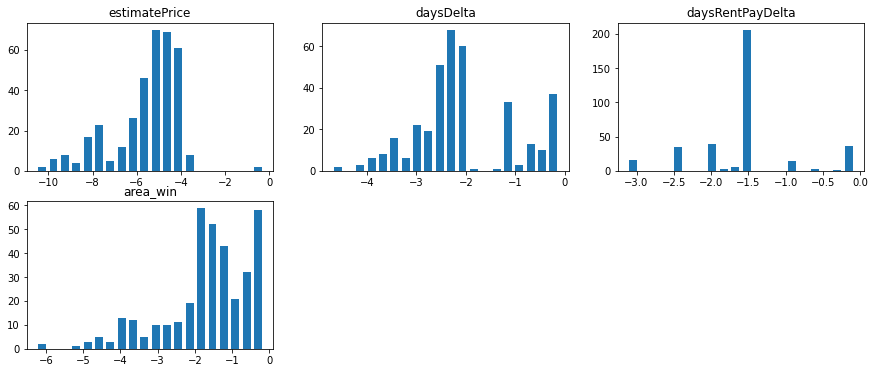

In [52]:
visualize_distributions({
    'estimatePrice': df_num2['estimatePrice'],    
    'daysDelta': df_num2['daysDelta'],
    'daysRentPayDelta': df_num2['daysRentPayDelta'],
    'area_win': df_num2['area_win']        
})

As we can see all the features except **area_win** feature now look more close to a Normal distribution, so probably it makes sense to use logarithmization of these three features, but we will check this hypothesis later when doing experiments. For now we will keep the numerical features as is.

### Let's now take a look at categorical features

Basically, what we need to do alter categorical features either with One hot encoding or with labelling

In [53]:
df_cat = df[cat_col]

In [54]:
# Label Encoding
for column in cat_col:
    df_cat[column] = df_cat[column].astype('category').cat.codes

<ipython-input-54-92abb00026ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cat[column] = df_cat[column].astype('category').cat.codes


In [55]:
# One-Hot Encoding
df_cat = pd.get_dummies(df_cat, columns=cat_col, dummy_na=False)

In [56]:
df_cat.head()

,status_0,region_id_0,region_id_1,region_id_2,region_id_3,region_id_4,region_id_5,region_id_6,region_id_7,region_id_8,...,estimateDay_26,estimateDay_27,estimateDay_28,estimateDay_29,estimateDay_30,estimateYear_0,estimateYear_1,estimateYear_2,daysRentPayDeltaSign_0,daysRentPayDeltaSign_1
0,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [57]:
df_cat.shape

(359, 754)

### Let's now concatenate both categorical and numerical feature after preprocessing into one DataFrame

In [58]:
df_result = pd.concat([df_num, df_cat], axis=1)

In [59]:
df_result.shape

(359, 759)

In [60]:
df_result.head()

,estimatePrice,rentalYield,daysDelta,daysRentPayDelta,area_win,status_0,region_id_0,region_id_1,region_id_2,region_id_3,...,estimateDay_26,estimateDay_27,estimateDay_28,estimateDay_29,estimateDay_30,estimateYear_0,estimateYear_1,estimateYear_2,daysRentPayDeltaSign_0,daysRentPayDeltaSign_1
0,0.004500,0.320000,0.000000,0.237748,0.178416,1,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
1,0.000617,0.146667,0.000000,0.237748,0.094461,1,0,0,0,0,...,0,1,0,0,0,0,0,1,1,0
2,0.021761,0.306667,0.097070,0.237748,0.985136,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0.015160,0.613333,0.097070,0.237748,0.548589,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0.019952,0.573333,0.017399,0.428050,0.684835,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [61]:
#Checking for the NaN values just in case
df_result.isnull().sum().sum()

0

Well, I guess we're ready to experiment with the models

## Models

In [62]:
# Splitting data
X_train, X_valid, y_train, y_valid = train_test_split(df_result, y, test_size=VAL_SIZE, shuffle = True, random_state=RANDOM_SEED)

## Model 1: Simple Linear Regression

In [63]:
linreg_model = LinearRegression().fit(X_train, y_train)

In [64]:
y_pred = linreg_model.predict(X_valid)
print(f"The precision of the Linear Regression model on MAPE metric is: {(mape(y_valid, y_pred))*100:0.2f}%")

The precision of the Linear Regression model on MAPE metric is: 23338258679164.05%


Obviously, the default linear regression model doesn't fir for this dataset. Let's try to build a linear regression model basen only on a numeric features

### Model 1.2: Simple Linear Regression Numeric Features Only

In [65]:
df_res_num = df_result[['estimatePrice', 'daysDelta', 'daysRentPayDelta', 'area_win']]

In [66]:
# Splitting data
X_train_num, X_valid_num, y_train_num, y_valid_num = train_test_split(df_res_num, y, test_size=VAL_SIZE, shuffle = True, random_state=RANDOM_SEED)

In [67]:
linreg_num_model = LinearRegression().fit(X_train_num, y_train_num)

In [68]:
y_pred_num = linreg_num_model.predict(X_valid_num)
print(f"The precision of the Linear Regression model on MAPE metric is: {(mape(y_valid_num, y_pred_num))*100:0.2f}%")

The precision of the Linear Regression model on MAPE metric is: 47.30%


Well, the result which is based only on numeric features is definitely better than the one with all the features, but it is still worse than the results of the default model. It looks like Linear Regression is definitely not the best model to use in this case.

## Model 2: CatboostRegressor

In [69]:
model_catboost = CatBoostRegressor(iterations = 5000,                       
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500                          
                         )
model_catboost.fit(X_train, y_train,
         eval_set=(X_valid, y_valid),
         verbose_eval=100,
         use_best_model=True       
         )

Learning rate set to 0.015833
0:	learn: 0.5163831	test: 0.4887893	best: 0.4887893 (0)	total: 154ms	remaining: 12m 50s
100:	learn: 0.3591576	test: 0.3384567	best: 0.3384567 (100)	total: 446ms	remaining: 21.6s
200:	learn: 0.2883918	test: 0.2758998	best: 0.2758427 (199)	total: 667ms	remaining: 15.9s
300:	learn: 0.2484842	test: 0.2443851	best: 0.2443851 (300)	total: 980ms	remaining: 15.3s
400:	learn: 0.2172466	test: 0.2248070	best: 0.2248070 (400)	total: 1.21s	remaining: 13.9s
500:	learn: 0.1949996	test: 0.2159439	best: 0.2159381 (499)	total: 1.58s	remaining: 14.2s
600:	learn: 0.1741024	test: 0.2077667	best: 0.2077656 (599)	total: 1.84s	remaining: 13.5s
700:	learn: 0.1572445	test: 0.2022013	best: 0.2021932 (699)	total: 2.08s	remaining: 12.8s
800:	learn: 0.1477150	test: 0.1991539	best: 0.1989908 (798)	total: 2.3s	remaining: 12.1s
900:	learn: 0.1384819	test: 0.1964452	best: 0.1964401 (899)	total: 2.52s	remaining: 11.5s
1000:	learn: 0.1301963	test: 0.1939316	best: 0.1939281 (999)	total: 2.74s

In [70]:
test_predict_catboost = model_catboost.predict(X_valid)
print(f"The precision of the Catboosting Regressor by the MAPE metrics is: {(mape(y_valid, test_predict_catboost))*100:0.2f}%")

The precision of the Catboosting Regressor by the MAPE metrics is: 16.30%


So, with initial CatBoost setup we were able to improve the default model metrics and get pretty good result. Let's think how to improve it

## Model 3: Gradient Boosting

In [71]:
# Default Gradient Bossting Regressor
model_gbr = GradientBoostingRegressor(n_estimators=300, random_state=RANDOM_SEED)
model_gbr.fit(X_train, y_train)
y_pred_gbr = model_gbr.predict(X_valid)
print(f"The precision of the default Gradient Bossting Regressor model on MAPE metric is: {(mape(y_valid, y_pred_gbr))*100:0.2f}%")

The precision of the default Gradient Bossting Regressor model on MAPE metric is: 17.75%


As we can see the result of the default Gradient Boosting Regressor model is much better than default model, however, not as good as CatBoosting. Let's try to fine-tune the Gradient Boosting with hyperparameters

### Model 3.1: Gradient Boosting with Hyperparameters Tuned

In [72]:
gbr = GradientBoostingRegressor()
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

In [73]:
# Using Grid Search to find the best parameters
'''cv_gbr = GridSearchCV(gbr,parameters,cv=5, n_jobs=-1)
cv_gbr.fit(X_train,y_train)'''

'cv_gbr = GridSearchCV(gbr,parameters,cv=5, n_jobs=-1)\ncv_gbr.fit(X_train,y_train)'

In [74]:
#cv_gbr.best_params_

In [75]:
# Gradient Bossting Regressor with hyperparameters tuned
model_gbr_1 = GradientBoostingRegressor(n_estimators=250, learning_rate= 0.1, max_depth=5, random_state=RANDOM_SEED)
model_gbr_1.fit(X_train, y_train)
y_pred_gbr_1 = model_gbr_1.predict(X_valid)
print(f"The precision of the Gradient Bossting Regressor with hyperparameters tuned on MAPE metric is: {(mape(y_valid, y_pred_gbr_1))*100:0.2f}%")

The precision of the Gradient Bossting Regressor with hyperparameters tuned on MAPE metric is: 16.56%


Wow, with the hyperparameters tuned for Gradient Booster Regressor we were able to achieve even better score than CatBoosting Regressor. 

## Model 4:  Default Decision Tree Regressor

In [76]:
# Default Decision Tree Regressor
model_dectree = DecisionTreeRegressor(random_state = RANDOM_SEED)
model_dectree.fit(X_train, y_train)
y_pred_dectree = model_dectree.predict(X_valid)
print(f"The precision of the DecisionTreeRegressor model by the MAPE metrics is: {(mape(y_valid, y_pred_dectree))*100:0.2f}%")

The precision of the DecisionTreeRegressor model by the MAPE metrics is: 18.51%


### Model 4.1 Decision Tree Regressor With Hyperparameters Tuned

Well, the the results of the default Decision Tree Model are not very promising, but anyway let's try to play with the hyperparameters tuning

In [77]:
dtr = DecisionTreeRegressor(random_state = RANDOM_SEED)

parameters_dtr = {"splitter":["best","random"],
            "max_depth" : [7,9,11,12],
           "min_samples_leaf":[1,2,3,6,7,8],
           "min_weight_fraction_leaf":[0.1,0.3, 0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50] }

In [78]:
# Using Grid Search to find the best parameters
#cv_dtr = GridSearchCV(dtr,parameters_dtr, cv=5, n_jobs=-1)
#cv_dtr.fit(X_train,y_train)

In [79]:
# best hyperparameters
#cv_dtr.best_params_

In [80]:
# Decision Tree Regressor with the best hyperparameters
model_dectree_1 = DecisionTreeRegressor(max_depth = 7, max_features = 'auto', min_samples_leaf = 1,
                                      min_weight_fraction_leaf = 0.1, splitter = 'best', random_state = RANDOM_SEED)
model_dectree_1.fit(X_train, y_train)
y_pred_dectree_1 = model_dectree_1.predict(X_valid)
print(f"The precision of the DecisionTreeRegressor model by the MAPE metrics is: {(mape(y_valid, y_pred_dectree_1))*100:0.2f}%")

The precision of the DecisionTreeRegressor model by the MAPE metrics is: 38.77%


The Decision Tree regressor with hyperparameters tuned showed even worse result than without hyperparameters. So, we would probably refuse using this model

## Model 5: Random Forest Regressor

In [81]:
# Default Random Forest Regressor
model_randfor = RandomForestRegressor(n_estimators = 100, random_state = RANDOM_SEED)
model_randfor.fit(X_train, y_train)  
y_pred_randfor = model_randfor.predict(X_valid)
print(f"The precision of the default Random Forest Regressor on the MAPE metrics is: {(mape(y_valid, y_pred_randfor))*100:0.2f}%")

The precision of the default Random Forest Regressor on the MAPE metrics is: 18.13%


As we can see the default Random Forest Regressor showed approximately the same accuracy as the default Gradient Bossting Regressor. So, let's try to play with the hyperparameters to improve the result

### Model 5.1: Random Forest Regressor with the hypermarameters tuned

In [82]:
rf = RandomForestRegressor()

parameters_rf = {
    'bootstrap': [True, False],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3, 5, 10],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [83]:
# Using Grid Search to find the best parameters
#cv_randf = GridSearchCV(rf, parameters_rf,cv = 5, n_jobs = -1, verbose = 2)
#cv_randf.fit(X_train, y_train)

In [84]:
# best parameters
#cv_randf.best_params_

In [85]:
# Random Forest Regressor with the best hyperparameters
model_randfor_1 = RandomForestRegressor(bootstrap= 'False', max_depth = 110, max_features = 10, min_samples_leaf = 3, 
                                        min_samples_split = 10, n_estimators = 100, random_state = RANDOM_SEED)
model_randfor_1.fit(X_train, y_train)  
y_pred_randfor_1 = model_randfor_1.predict(X_valid)
print(f"The precision of the Random Forest Regressor with the hyperparameters on the MAPE metrics is: {(mape(y_valid, y_pred_randfor_1))*100:0.2f}%")

The precision of the Random Forest Regressor with the hyperparameters on the MAPE metrics is: 45.69%


As we can see the result of the Random Forest Regressor with the best hyperparameters is worse than the result of the default model. So, we will probably stick to the default model if using this algorithm at all

## Model 6: K-Nearest Neighbors Regressor

In [86]:
# Default K-Nearest Neighbours Regressor
model_knn = KNeighborsRegressor(n_neighbors=2)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_valid)
print(f"The precision of the default K-Nearest Neighbours Regressor on the MAPE metrics is: {(mape(y_valid, y_pred_knn))*100:0.2f}%")

The precision of the default K-Nearest Neighbours Regressor on the MAPE metrics is: 30.23%


The result of the default K-Nearest Neighbors Regressor doesn't look promising. Probably we even won't play with the hyperparameteres

## Model 7: Support Vector Machine Regressor

In [87]:
# Default Support Vector Machine Regressor
model_svm = SVR(kernel = 'rbf')
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_valid)
print(f"The precision of the default Support Vector Machine Regressor on the MAPE metrics is: {(mape(y_valid, y_pred_svm))*100:0.2f}%")

The precision of the default Support Vector Machine Regressor on the MAPE metrics is: 47.31%


The result of the default Support Vector Machine Regressor doesn't look promising. Probably we even won't play with the hyperparameteres

## Model 8: Ensemble of the Regressors

Let's now try to teach an ensemple of the regression models that prooved themselves the best

In [88]:
# Define basic models
level0 = list()
level0.append(('catb', CatBoostRegressor()))
level0.append(('rand', RandomForestRegressor()))
level0.append(('gradb', GradientBoostingRegressor()))

In [89]:
# Define meta-model
level1 = LinearRegression()

In [ ]:
# Ensemble model
model_ens = StackingRegressor(estimators=level0, final_estimator=level1, cv=5, verbose = 100)
model_ens.fit(X_train, y_train)  
y_pred_ens = model_ens.predict(X_valid)
print(f"The precision of the Ensemble Model by the MAPE metrics is: {(mape(y_valid, y_pred_ens))*100:0.2f}%")

Learning rate set to 0.033939
0:	learn: 23992.4215250	total: 12ms	remaining: 12s
1:	learn: 23747.6507880	total: 15.2ms	remaining: 7.59s
2:	learn: 23496.4424370	total: 18.3ms	remaining: 6.08s
3:	learn: 23279.6107259	total: 20.8ms	remaining: 5.17s
4:	learn: 22994.1623664	total: 23.7ms	remaining: 4.72s
5:	learn: 22836.0826845	total: 26.7ms	remaining: 4.42s
6:	learn: 22682.5470066	total: 30ms	remaining: 4.25s
7:	learn: 22469.6949604	total: 32.6ms	remaining: 4.04s
8:	learn: 22261.3390428	total: 35.9ms	remaining: 3.95s
9:	learn: 22080.3089902	total: 38.8ms	remaining: 3.84s
10:	learn: 21868.5621691	total: 41.6ms	remaining: 3.74s
11:	learn: 21708.2066010	total: 44.2ms	remaining: 3.64s
12:	learn: 21503.9089491	total: 47.1ms	remaining: 3.57s
13:	learn: 21311.9459871	total: 50.5ms	remaining: 3.56s
14:	learn: 21097.0584895	total: 53.3ms	remaining: 3.5s
15:	learn: 20892.5939363	total: 56.2ms	remaining: 3.46s
16:	learn: 20718.2518612	total: 58.8ms	remaining: 3.4s
17:	learn: 20540.6478050	total: 61.1

155:	learn: 11948.8052297	total: 447ms	remaining: 2.42s
156:	learn: 11923.1809381	total: 449ms	remaining: 2.41s
157:	learn: 11894.0249877	total: 452ms	remaining: 2.41s
158:	learn: 11871.5457952	total: 454ms	remaining: 2.4s
159:	learn: 11852.3120199	total: 457ms	remaining: 2.4s
160:	learn: 11834.0901815	total: 460ms	remaining: 2.4s
161:	learn: 11813.0772464	total: 462ms	remaining: 2.39s
162:	learn: 11767.3980746	total: 464ms	remaining: 2.38s
163:	learn: 11754.3251798	total: 467ms	remaining: 2.38s
164:	learn: 11721.8561505	total: 469ms	remaining: 2.37s
165:	learn: 11686.6699424	total: 471ms	remaining: 2.37s
166:	learn: 11673.4013395	total: 474ms	remaining: 2.36s
167:	learn: 11657.4599262	total: 477ms	remaining: 2.36s
168:	learn: 11641.9402681	total: 479ms	remaining: 2.35s
169:	learn: 11608.5940191	total: 481ms	remaining: 2.35s
170:	learn: 11579.7857791	total: 484ms	remaining: 2.34s
171:	learn: 11558.9896684	total: 486ms	remaining: 2.34s
172:	learn: 11514.1777419	total: 488ms	remaining: 2

326:	learn: 8362.1929106	total: 871ms	remaining: 1.79s
327:	learn: 8353.6279018	total: 873ms	remaining: 1.79s
328:	learn: 8343.1694556	total: 876ms	remaining: 1.79s
329:	learn: 8319.6601150	total: 878ms	remaining: 1.78s
330:	learn: 8313.4983556	total: 881ms	remaining: 1.78s
331:	learn: 8307.5728394	total: 883ms	remaining: 1.78s
332:	learn: 8301.7144741	total: 886ms	remaining: 1.77s
333:	learn: 8270.7779326	total: 888ms	remaining: 1.77s
334:	learn: 8264.7718717	total: 890ms	remaining: 1.77s
335:	learn: 8237.3781696	total: 893ms	remaining: 1.76s
336:	learn: 8221.5563229	total: 895ms	remaining: 1.76s
337:	learn: 8212.1021499	total: 898ms	remaining: 1.76s
338:	learn: 8201.7588680	total: 900ms	remaining: 1.75s
339:	learn: 8169.8940326	total: 902ms	remaining: 1.75s
340:	learn: 8164.0464898	total: 905ms	remaining: 1.75s
341:	learn: 8137.6952687	total: 907ms	remaining: 1.75s
342:	learn: 8115.8873909	total: 909ms	remaining: 1.74s
343:	learn: 8086.0142115	total: 912ms	remaining: 1.74s
344:	learn

484:	learn: 6618.2304967	total: 1.26s	remaining: 1.34s
485:	learn: 6614.3351105	total: 1.26s	remaining: 1.34s
486:	learn: 6610.5080083	total: 1.27s	remaining: 1.33s
487:	learn: 6598.2606937	total: 1.27s	remaining: 1.33s
488:	learn: 6572.7495583	total: 1.27s	remaining: 1.33s
489:	learn: 6568.7883651	total: 1.27s	remaining: 1.33s
490:	learn: 6560.1998526	total: 1.28s	remaining: 1.32s
491:	learn: 6556.2175271	total: 1.28s	remaining: 1.32s
492:	learn: 6550.4580026	total: 1.28s	remaining: 1.32s
493:	learn: 6546.3029257	total: 1.28s	remaining: 1.31s
494:	learn: 6523.0985241	total: 1.29s	remaining: 1.31s
495:	learn: 6519.1581533	total: 1.29s	remaining: 1.31s
496:	learn: 6509.5251533	total: 1.29s	remaining: 1.31s
497:	learn: 6505.4362904	total: 1.29s	remaining: 1.3s
498:	learn: 6501.7269577	total: 1.3s	remaining: 1.3s
499:	learn: 6496.4730625	total: 1.3s	remaining: 1.3s
500:	learn: 6492.4452503	total: 1.3s	remaining: 1.3s
501:	learn: 6486.5580978	total: 1.3s	remaining: 1.29s
502:	learn: 6479.4

640:	learn: 5471.7747819	total: 1.61s	remaining: 905ms
641:	learn: 5456.4306567	total: 1.62s	remaining: 902ms
642:	learn: 5453.5084923	total: 1.62s	remaining: 900ms
643:	learn: 5442.9934101	total: 1.62s	remaining: 897ms
644:	learn: 5429.0862064	total: 1.62s	remaining: 894ms
645:	learn: 5426.3123581	total: 1.63s	remaining: 892ms
646:	learn: 5423.7971496	total: 1.63s	remaining: 889ms
647:	learn: 5421.0068901	total: 1.63s	remaining: 886ms
648:	learn: 5416.9186624	total: 1.63s	remaining: 883ms
649:	learn: 5414.0277762	total: 1.64s	remaining: 881ms
650:	learn: 5409.9471128	total: 1.64s	remaining: 878ms
651:	learn: 5405.4421219	total: 1.64s	remaining: 875ms
652:	learn: 5402.7550617	total: 1.64s	remaining: 873ms
653:	learn: 5399.9770916	total: 1.64s	remaining: 870ms
654:	learn: 5397.1180218	total: 1.65s	remaining: 868ms
655:	learn: 5392.5753170	total: 1.65s	remaining: 865ms
656:	learn: 5385.7148272	total: 1.65s	remaining: 862ms
657:	learn: 5373.2113346	total: 1.65s	remaining: 860ms
658:	learn

812:	learn: 4456.7157182	total: 2.16s	remaining: 497ms
813:	learn: 4454.7072511	total: 2.16s	remaining: 495ms
814:	learn: 4446.8825642	total: 2.17s	remaining: 492ms
815:	learn: 4441.9164479	total: 2.17s	remaining: 489ms
816:	learn: 4439.7138636	total: 2.17s	remaining: 486ms
817:	learn: 4437.5406209	total: 2.17s	remaining: 484ms
818:	learn: 4435.5663736	total: 2.18s	remaining: 481ms
819:	learn: 4433.4735064	total: 2.18s	remaining: 478ms
820:	learn: 4431.5238314	total: 2.18s	remaining: 476ms
821:	learn: 4421.5624661	total: 2.18s	remaining: 473ms
822:	learn: 4414.0937543	total: 2.19s	remaining: 470ms
823:	learn: 4411.9390628	total: 2.19s	remaining: 467ms
824:	learn: 4408.7105177	total: 2.19s	remaining: 465ms
825:	learn: 4406.7591024	total: 2.19s	remaining: 462ms
826:	learn: 4399.9827013	total: 2.19s	remaining: 459ms
827:	learn: 4397.8266943	total: 2.2s	remaining: 456ms
828:	learn: 4395.6990997	total: 2.2s	remaining: 454ms
829:	learn: 4392.9138862	total: 2.2s	remaining: 451ms
830:	learn: 4

969:	learn: 3818.5482522	total: 2.52s	remaining: 77.8ms
970:	learn: 3815.8648895	total: 2.52s	remaining: 75.2ms
971:	learn: 3814.1049606	total: 2.52s	remaining: 72.6ms
972:	learn: 3812.3522921	total: 2.52s	remaining: 70ms
973:	learn: 3810.7450781	total: 2.52s	remaining: 67.4ms
974:	learn: 3808.1385056	total: 2.53s	remaining: 64.8ms
975:	learn: 3797.2531921	total: 2.53s	remaining: 62.2ms
976:	learn: 3793.0110955	total: 2.53s	remaining: 59.6ms
977:	learn: 3790.6885802	total: 2.53s	remaining: 57ms
978:	learn: 3788.9374676	total: 2.54s	remaining: 54.4ms
979:	learn: 3787.2053771	total: 2.54s	remaining: 51.8ms
980:	learn: 3781.9982359	total: 2.54s	remaining: 49.2ms
981:	learn: 3780.3375173	total: 2.54s	remaining: 46.6ms
982:	learn: 3771.7377966	total: 2.54s	remaining: 44ms
983:	learn: 3769.8659160	total: 2.55s	remaining: 41.4ms
984:	learn: 3768.0165554	total: 2.55s	remaining: 38.8ms
985:	learn: 3756.8683692	total: 2.55s	remaining: 36.2ms
986:	learn: 3755.1523449	total: 2.55s	remaining: 33.6m

163:	learn: 11901.2798640	total: 294ms	remaining: 1.5s
164:	learn: 11840.3739993	total: 296ms	remaining: 1.5s
165:	learn: 11783.0793413	total: 298ms	remaining: 1.5s
166:	learn: 11751.4756380	total: 299ms	remaining: 1.49s
167:	learn: 11729.8621372	total: 301ms	remaining: 1.49s
168:	learn: 11680.6494784	total: 303ms	remaining: 1.49s
169:	learn: 11645.5000717	total: 305ms	remaining: 1.49s
170:	learn: 11608.8452402	total: 307ms	remaining: 1.49s
171:	learn: 11581.7329132	total: 308ms	remaining: 1.48s
172:	learn: 11566.7311419	total: 310ms	remaining: 1.48s
173:	learn: 11539.4993771	total: 312ms	remaining: 1.48s
174:	learn: 11497.8184354	total: 313ms	remaining: 1.48s
175:	learn: 11470.4897509	total: 315ms	remaining: 1.47s
176:	learn: 11411.4849246	total: 317ms	remaining: 1.47s
177:	learn: 11389.9055032	total: 319ms	remaining: 1.47s
178:	learn: 11365.1259064	total: 320ms	remaining: 1.47s
179:	learn: 11340.6233234	total: 322ms	remaining: 1.47s
180:	learn: 11315.7306728	total: 324ms	remaining: 1

371:	learn: 7664.1558389	total: 646ms	remaining: 1.09s
372:	learn: 7652.3430020	total: 648ms	remaining: 1.09s
373:	learn: 7645.7901140	total: 649ms	remaining: 1.09s
374:	learn: 7639.4688099	total: 651ms	remaining: 1.08s
375:	learn: 7633.2044493	total: 653ms	remaining: 1.08s
376:	learn: 7627.1621129	total: 654ms	remaining: 1.08s
377:	learn: 7620.5681934	total: 656ms	remaining: 1.08s
378:	learn: 7612.9919648	total: 658ms	remaining: 1.08s
379:	learn: 7606.6482900	total: 660ms	remaining: 1.08s
380:	learn: 7574.7379684	total: 661ms	remaining: 1.07s
381:	learn: 7568.6751676	total: 663ms	remaining: 1.07s
382:	learn: 7563.1461662	total: 665ms	remaining: 1.07s
383:	learn: 7556.7818135	total: 666ms	remaining: 1.07s
384:	learn: 7550.6620469	total: 668ms	remaining: 1.07s
385:	learn: 7544.6098925	total: 670ms	remaining: 1.06s
386:	learn: 7538.4234705	total: 671ms	remaining: 1.06s
387:	learn: 7532.0108758	total: 673ms	remaining: 1.06s
388:	learn: 7526.4160246	total: 675ms	remaining: 1.06s
389:	learn

569:	learn: 5806.4437091	total: 996ms	remaining: 751ms
570:	learn: 5801.5693293	total: 998ms	remaining: 750ms
571:	learn: 5798.0839708	total: 1000ms	remaining: 748ms
572:	learn: 5794.4845915	total: 1s	remaining: 746ms
573:	learn: 5788.4971807	total: 1s	remaining: 745ms
574:	learn: 5782.9098785	total: 1s	remaining: 743ms
575:	learn: 5779.7637305	total: 1.01s	remaining: 741ms
576:	learn: 5773.9428873	total: 1.01s	remaining: 740ms
577:	learn: 5770.3670734	total: 1.01s	remaining: 738ms
578:	learn: 5754.4018399	total: 1.01s	remaining: 736ms
579:	learn: 5750.7544103	total: 1.01s	remaining: 734ms
580:	learn: 5747.4764843	total: 1.01s	remaining: 732ms
581:	learn: 5743.9482951	total: 1.02s	remaining: 731ms
582:	learn: 5725.2304526	total: 1.02s	remaining: 729ms
583:	learn: 5720.0560246	total: 1.02s	remaining: 727ms
584:	learn: 5714.7582773	total: 1.02s	remaining: 725ms
585:	learn: 5706.2206078	total: 1.02s	remaining: 723ms
586:	learn: 5702.6907420	total: 1.02s	remaining: 722ms
587:	learn: 5698.8

771:	learn: 4557.5203525	total: 1.34s	remaining: 398ms
772:	learn: 4554.9939806	total: 1.35s	remaining: 396ms
773:	learn: 4546.9820814	total: 1.35s	remaining: 394ms
774:	learn: 4536.2294112	total: 1.35s	remaining: 392ms
775:	learn: 4532.8815372	total: 1.35s	remaining: 391ms
776:	learn: 4530.2331569	total: 1.35s	remaining: 389ms
777:	learn: 4527.7300771	total: 1.36s	remaining: 387ms
778:	learn: 4516.0756325	total: 1.36s	remaining: 385ms
779:	learn: 4513.5755526	total: 1.36s	remaining: 384ms
780:	learn: 4498.0634820	total: 1.36s	remaining: 382ms
781:	learn: 4482.4436191	total: 1.36s	remaining: 380ms
782:	learn: 4473.2097395	total: 1.37s	remaining: 379ms
783:	learn: 4470.7392709	total: 1.37s	remaining: 377ms
784:	learn: 4462.5804930	total: 1.37s	remaining: 375ms
785:	learn: 4458.9759834	total: 1.37s	remaining: 373ms
786:	learn: 4456.4820187	total: 1.37s	remaining: 372ms
787:	learn: 4445.1875886	total: 1.37s	remaining: 370ms
788:	learn: 4439.8590351	total: 1.38s	remaining: 368ms
789:	learn

971:	learn: 3627.1015801	total: 1.7s	remaining: 48.9ms
972:	learn: 3625.3104916	total: 1.7s	remaining: 47.2ms
973:	learn: 3623.6735794	total: 1.7s	remaining: 45.4ms
974:	learn: 3619.6806316	total: 1.7s	remaining: 43.7ms
975:	learn: 3615.8640800	total: 1.71s	remaining: 41.9ms
976:	learn: 3608.5751396	total: 1.71s	remaining: 40.2ms
977:	learn: 3606.8986010	total: 1.71s	remaining: 38.5ms
978:	learn: 3605.1334361	total: 1.71s	remaining: 36.7ms
979:	learn: 3603.4273648	total: 1.71s	remaining: 35ms
980:	learn: 3601.7800678	total: 1.71s	remaining: 33.2ms
981:	learn: 3590.1350366	total: 1.72s	remaining: 31.5ms
982:	learn: 3588.2652416	total: 1.72s	remaining: 29.7ms
983:	learn: 3586.4935618	total: 1.72s	remaining: 28ms
984:	learn: 3584.7397668	total: 1.72s	remaining: 26.2ms
985:	learn: 3582.9802545	total: 1.72s	remaining: 24.5ms
986:	learn: 3573.5565568	total: 1.73s	remaining: 22.7ms
987:	learn: 3571.9318604	total: 1.73s	remaining: 21ms
988:	learn: 3563.7971217	total: 1.73s	remaining: 19.2ms
98

118:	learn: 13467.0701858	total: 206ms	remaining: 1.52s
119:	learn: 13411.6778700	total: 208ms	remaining: 1.52s
120:	learn: 13352.0031403	total: 210ms	remaining: 1.52s
121:	learn: 13323.0158263	total: 211ms	remaining: 1.52s
122:	learn: 13300.8122794	total: 213ms	remaining: 1.52s
123:	learn: 13263.7622570	total: 215ms	remaining: 1.52s
124:	learn: 13209.8763143	total: 218ms	remaining: 1.52s
125:	learn: 13162.3961339	total: 220ms	remaining: 1.52s
126:	learn: 13143.2780842	total: 221ms	remaining: 1.52s
127:	learn: 13113.0710226	total: 223ms	remaining: 1.52s
128:	learn: 13094.9474208	total: 225ms	remaining: 1.52s
129:	learn: 13075.7925506	total: 226ms	remaining: 1.51s
130:	learn: 13044.3102081	total: 228ms	remaining: 1.51s
131:	learn: 13010.6379568	total: 230ms	remaining: 1.51s
132:	learn: 12976.2767751	total: 232ms	remaining: 1.51s
133:	learn: 12927.4950636	total: 233ms	remaining: 1.51s
134:	learn: 12902.8257889	total: 235ms	remaining: 1.51s
135:	learn: 12862.4239144	total: 237ms	remaining

322:	learn: 8659.6393034	total: 555ms	remaining: 1.16s
323:	learn: 8651.7537957	total: 557ms	remaining: 1.16s
324:	learn: 8631.3357651	total: 559ms	remaining: 1.16s
325:	learn: 8624.1272161	total: 561ms	remaining: 1.16s
326:	learn: 8608.6613608	total: 563ms	remaining: 1.16s
327:	learn: 8597.8257855	total: 565ms	remaining: 1.16s
328:	learn: 8557.5158381	total: 567ms	remaining: 1.16s
329:	learn: 8550.0888732	total: 568ms	remaining: 1.15s
330:	learn: 8542.7768318	total: 570ms	remaining: 1.15s
331:	learn: 8535.1924772	total: 572ms	remaining: 1.15s
332:	learn: 8524.7143907	total: 573ms	remaining: 1.15s
333:	learn: 8515.4946391	total: 575ms	remaining: 1.15s
334:	learn: 8508.3440408	total: 577ms	remaining: 1.14s
335:	learn: 8501.2776796	total: 578ms	remaining: 1.14s
336:	learn: 8494.0196685	total: 580ms	remaining: 1.14s
337:	learn: 8486.8770810	total: 582ms	remaining: 1.14s
338:	learn: 8463.9391828	total: 583ms	remaining: 1.14s
339:	learn: 8457.0155881	total: 585ms	remaining: 1.14s
340:	learn

529:	learn: 6459.2847772	total: 907ms	remaining: 804ms
530:	learn: 6455.5391951	total: 908ms	remaining: 802ms
531:	learn: 6450.9840281	total: 910ms	remaining: 801ms
532:	learn: 6425.6936085	total: 912ms	remaining: 799ms
533:	learn: 6421.4313115	total: 914ms	remaining: 797ms
534:	learn: 6417.6648644	total: 915ms	remaining: 796ms
535:	learn: 6411.6835008	total: 917ms	remaining: 794ms
536:	learn: 6393.6150058	total: 919ms	remaining: 792ms
537:	learn: 6389.9110566	total: 921ms	remaining: 791ms
538:	learn: 6385.7311074	total: 923ms	remaining: 789ms
539:	learn: 6381.8899687	total: 924ms	remaining: 787ms
540:	learn: 6377.5584701	total: 926ms	remaining: 786ms
541:	learn: 6373.4505113	total: 928ms	remaining: 784ms
542:	learn: 6367.7322125	total: 929ms	remaining: 782ms
543:	learn: 6364.0409330	total: 931ms	remaining: 780ms
544:	learn: 6360.6896865	total: 932ms	remaining: 778ms
545:	learn: 6356.7071861	total: 934ms	remaining: 777ms
546:	learn: 6352.6430778	total: 936ms	remaining: 775ms
547:	learn

737:	learn: 4967.7791874	total: 1.26s	remaining: 446ms
738:	learn: 4964.6955957	total: 1.26s	remaining: 445ms
739:	learn: 4961.8580865	total: 1.26s	remaining: 443ms
740:	learn: 4955.2111055	total: 1.26s	remaining: 442ms
741:	learn: 4952.3947711	total: 1.26s	remaining: 440ms
742:	learn: 4949.6423557	total: 1.27s	remaining: 438ms
743:	learn: 4940.0730062	total: 1.27s	remaining: 436ms
744:	learn: 4937.3695481	total: 1.27s	remaining: 435ms
745:	learn: 4931.6454626	total: 1.27s	remaining: 433ms
746:	learn: 4914.2192384	total: 1.27s	remaining: 431ms
747:	learn: 4911.6409900	total: 1.27s	remaining: 430ms
748:	learn: 4909.0994002	total: 1.28s	remaining: 428ms
749:	learn: 4903.3798964	total: 1.28s	remaining: 426ms
750:	learn: 4900.7595356	total: 1.28s	remaining: 424ms
751:	learn: 4896.7543850	total: 1.28s	remaining: 423ms
752:	learn: 4890.7914536	total: 1.28s	remaining: 421ms
753:	learn: 4888.0877456	total: 1.28s	remaining: 419ms
754:	learn: 4885.5855919	total: 1.29s	remaining: 418ms
755:	learn

942:	learn: 3938.8006913	total: 1.61s	remaining: 97.3ms
943:	learn: 3937.0885316	total: 1.61s	remaining: 95.6ms
944:	learn: 3930.9166298	total: 1.61s	remaining: 93.9ms
945:	learn: 3916.1091973	total: 1.61s	remaining: 92.2ms
946:	learn: 3914.1103957	total: 1.62s	remaining: 90.5ms
947:	learn: 3903.9473767	total: 1.62s	remaining: 88.8ms
948:	learn: 3900.5917832	total: 1.62s	remaining: 87.1ms
949:	learn: 3898.6075761	total: 1.62s	remaining: 85.4ms
950:	learn: 3892.0138150	total: 1.62s	remaining: 83.7ms
951:	learn: 3890.1044557	total: 1.63s	remaining: 82ms
952:	learn: 3887.8379748	total: 1.63s	remaining: 80.3ms
953:	learn: 3880.2840820	total: 1.63s	remaining: 78.5ms
954:	learn: 3878.5300790	total: 1.63s	remaining: 76.8ms
955:	learn: 3876.5863096	total: 1.63s	remaining: 75.1ms
956:	learn: 3874.1104687	total: 1.63s	remaining: 73.4ms
957:	learn: 3871.4943917	total: 1.64s	remaining: 71.7ms
958:	learn: 3869.5660835	total: 1.64s	remaining: 70ms
959:	learn: 3867.2823421	total: 1.64s	remaining: 68.

171:	learn: 11414.9996838	total: 304ms	remaining: 1.47s
172:	learn: 11395.2633633	total: 306ms	remaining: 1.46s
173:	learn: 11340.8143694	total: 308ms	remaining: 1.46s
174:	learn: 11309.0436196	total: 310ms	remaining: 1.46s
175:	learn: 11285.5160189	total: 312ms	remaining: 1.46s
176:	learn: 11270.4197849	total: 313ms	remaining: 1.46s
177:	learn: 11255.4447561	total: 315ms	remaining: 1.46s
178:	learn: 11225.0892813	total: 317ms	remaining: 1.45s
179:	learn: 11202.8762582	total: 319ms	remaining: 1.45s
180:	learn: 11174.7027235	total: 321ms	remaining: 1.45s
181:	learn: 11140.8805036	total: 322ms	remaining: 1.45s
182:	learn: 11119.0473393	total: 324ms	remaining: 1.45s
183:	learn: 11094.4082112	total: 326ms	remaining: 1.44s
184:	learn: 11057.6749165	total: 328ms	remaining: 1.44s
185:	learn: 11011.3873261	total: 329ms	remaining: 1.44s
186:	learn: 10990.4528623	total: 331ms	remaining: 1.44s
187:	learn: 10971.9078787	total: 333ms	remaining: 1.44s
188:	learn: 10959.4532968	total: 334ms	remaining

376:	learn: 7272.1148990	total: 656ms	remaining: 1.08s
377:	learn: 7266.7341427	total: 658ms	remaining: 1.08s
378:	learn: 7261.0186312	total: 660ms	remaining: 1.08s
379:	learn: 7255.8187240	total: 661ms	remaining: 1.08s
380:	learn: 7250.6688924	total: 663ms	remaining: 1.08s
381:	learn: 7219.2172175	total: 665ms	remaining: 1.07s
382:	learn: 7208.7867149	total: 667ms	remaining: 1.07s
383:	learn: 7203.5968504	total: 669ms	remaining: 1.07s
384:	learn: 7189.4432742	total: 671ms	remaining: 1.07s
385:	learn: 7184.3018534	total: 673ms	remaining: 1.07s
386:	learn: 7175.3288484	total: 674ms	remaining: 1.07s
387:	learn: 7166.8969122	total: 676ms	remaining: 1.07s
388:	learn: 7161.4976736	total: 678ms	remaining: 1.06s
389:	learn: 7131.2658461	total: 680ms	remaining: 1.06s
390:	learn: 7126.2245830	total: 681ms	remaining: 1.06s
391:	learn: 7112.0857016	total: 683ms	remaining: 1.06s
392:	learn: 7107.0868197	total: 685ms	remaining: 1.06s
393:	learn: 7098.2088725	total: 686ms	remaining: 1.05s
394:	learn

582:	learn: 5509.7060689	total: 1.01s	remaining: 720ms
583:	learn: 5501.1194040	total: 1.01s	remaining: 719ms
584:	learn: 5497.7312919	total: 1.01s	remaining: 717ms
585:	learn: 5492.2106690	total: 1.01s	remaining: 715ms
586:	learn: 5464.5686588	total: 1.01s	remaining: 713ms
587:	learn: 5457.6051275	total: 1.01s	remaining: 712ms
588:	learn: 5454.4591200	total: 1.02s	remaining: 710ms
589:	learn: 5442.2708900	total: 1.02s	remaining: 709ms
590:	learn: 5437.0000266	total: 1.02s	remaining: 707ms
591:	learn: 5414.0561842	total: 1.02s	remaining: 705ms
592:	learn: 5410.8502908	total: 1.02s	remaining: 703ms
593:	learn: 5400.5447995	total: 1.03s	remaining: 702ms
594:	learn: 5376.1351566	total: 1.03s	remaining: 700ms
595:	learn: 5372.7276375	total: 1.03s	remaining: 698ms
596:	learn: 5367.7615977	total: 1.03s	remaining: 697ms
597:	learn: 5364.1422660	total: 1.03s	remaining: 695ms
598:	learn: 5360.8856954	total: 1.03s	remaining: 693ms
599:	learn: 5357.7447515	total: 1.04s	remaining: 691ms
600:	learn

788:	learn: 4255.0819768	total: 1.36s	remaining: 363ms
789:	learn: 4251.3083379	total: 1.36s	remaining: 362ms
790:	learn: 4231.6255974	total: 1.36s	remaining: 360ms
791:	learn: 4229.2680097	total: 1.36s	remaining: 358ms
792:	learn: 4226.9211196	total: 1.36s	remaining: 356ms
793:	learn: 4222.3587488	total: 1.37s	remaining: 355ms
794:	learn: 4218.2004059	total: 1.37s	remaining: 353ms
795:	learn: 4211.8632060	total: 1.37s	remaining: 351ms
796:	learn: 4207.4384669	total: 1.37s	remaining: 350ms
797:	learn: 4203.2443590	total: 1.37s	remaining: 348ms
798:	learn: 4195.4921105	total: 1.38s	remaining: 346ms
799:	learn: 4193.1173781	total: 1.38s	remaining: 345ms
800:	learn: 4190.5839410	total: 1.38s	remaining: 343ms
801:	learn: 4188.3030288	total: 1.38s	remaining: 341ms
802:	learn: 4183.5951941	total: 1.38s	remaining: 339ms
803:	learn: 4180.6403026	total: 1.38s	remaining: 337ms
804:	learn: 4166.1280776	total: 1.39s	remaining: 336ms
805:	learn: 4161.4271255	total: 1.39s	remaining: 334ms
806:	learn

997:	learn: 3359.9136920	total: 1.71s	remaining: 3.42ms
998:	learn: 3358.4851885	total: 1.71s	remaining: 1.71ms
999:	learn: 3356.7209588	total: 1.71s	remaining: 0us
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.8s remaining:    0.0s
Learning rate set to 0.032763
0:	learn: 24092.8293796	total: 18.7ms	remaining: 18.7s
1:	learn: 23855.1356566	total: 21.2ms	remaining: 10.6s
2:	learn: 23607.2918388	total: 23.2ms	remaining: 7.7s
3:	learn: 23354.4291293	total: 25.2ms	remaining: 6.27s
4:	learn: 23114.9565140	total: 27.1ms	remaining: 5.39s
5:	learn: 22930.0361980	total: 28.9ms	remaining: 4.79s
6:	learn: 22736.5144497	total: 30.7ms	remaining: 4.35s
7:	learn: 22534.5571288	total: 32.4ms	remaining: 4.02s
8:	learn: 22334.2512873	total: 34.1ms	remaining: 3.75s
9:	learn: 22184.3162759	total: 35.8ms	remaining: 3.54s
10:	learn: 22030.4733845	total: 37.5ms	remaining: 3.37s
11:	learn: 21828.2508980	total: 39.2ms	remaining: 3.23s
12:	learn: 21674.9443004	total: 40.9ms	remaining: 3.1s
13:	learn

Unfortunately this particular ensemble of the regressors didn't show the improvement of the score that we saw in CatBooosting and Gradient Bossting Regressors

## Model 9: Simple Dense Neural Network

In [ ]:
# Simple Dense Neural Network
model_dnn = Sequential()
model_dnn.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_dnn.add(L.Dropout(0.5))
model_dnn.add(L.Dense(256, activation="relu"))
model_dnn.add(L.Dropout(0.5))
model_dnn.add(L.Dense(1, activation="linear"))

In [ ]:
model_dnn.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.01)
model_dnn.compile(loss='MAPE', optimizer = optimizer, metrics = ['MAPE'])
checkpoint_dnn = ModelCheckpoint('../working/best_model_dnn.hdf5', monitor = ['val_MAPE'], verbose=0, mode='min')
earlystop_dnn = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True)
callbacks_list_dnn = [checkpoint_dnn,earlystop_dnn]

In [ ]:
history_dnn = model_dnn.fit(X_train, y_train,
                   batch_size=512,
                   epochs = 500,
                   validation_data = (X_valid, y_valid),
                   callbacks = callbacks_list_dnn,
                   verbose = 0,
                   )

In [ ]:
plt.title('Loss')
plt.plot(history_dnn.history['MAPE'], label='train')
plt.plot(history_dnn.history['val_MAPE'], label='test')
plt.show();

In [ ]:
model_dnn.load_weights('../working/best_model_dnn.hdf5')
model_dnn.save('../working/nn_1.hdf5')

In [ ]:
test_predict_nn1 = model_dnn.predict(X_valid)[:, 0]
print(f"TEST MAPE:{(mape(y_valid, test_predict_nn1))*100:0.2f}%")

Unfortunately, simple Dense Neural Network with initial parameters wasn't able to produce any better results than regressors did

## Model 10: TabNet 

In [ ]:
# Reshaping data to the needed format
'''X = X_train.to_numpy()
y = y_train.to_numpy().reshape(-1, 1)
X_valid = X_valid.to_numpy()'''

In [ ]:
# TabNet Neural Network
'''model_tabnet = TabNetRegressor(verbose=0,seed=42)
model_tabnet.fit(X_train=X, y_train=y,
              eval_set=[(X_valid, y_valid)],
              patience=300, max_epochs=2000)'''

In [ ]:
'''test_predict_tabnet = model_tabnet.predict(X_valid)
print(f"The precision of TabNet Neural Network by the MAPE metrics is:{(mape(y_valid, test_predict_tabnet))*100:0.2f}%")'''

In [ ]:
'''kf = KFold(n_splits=5, random_state=42, shuffle=True)
predictions_array =[]
CV_score_array    =[]
for train_index, test_index in kf.split(X):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    regressor = TabNetRegressor(verbose=0,seed=42)
    regressor.fit(X_train=X_train, y_train=y_train,
              eval_set=[(X_valid, y_valid)],
              patience=300, max_epochs=2000,
              eval_metric=['rmse'])
    CV_score_array.append(regressor.best_cost)
    predictions_array.append(np.expm1(regressor.predict(X_valid)))

predictions = np.mean(predictions_array,axis=0)'''

In [ ]:
'''test_predict_tabnet_1 = regressor.predict(X_valid)
print(f"The precision of TabNet Neural Network by the MAPE metrics is:{(mape(y_valid, test_predict_tabnet_1))*100:0.2f}%")'''

## Model 11: Blend of the best models

Let's try now to use blend of the best models

In [ ]:
# Doing blend prediction of the Catboost algorithm and Gradiend Boosting
blend_predict_1 = (test_predict_catboost + y_pred_gbr_1) / 2
print(f"The precision of the blend of the best models by the MAPE metric is: {(mape(y_valid, blend_predict_1))*100:0.2f}%")

In [ ]:
# Doing blend prediction of the Catboost algorithm, Gradient Boosting and Random Forest
blend_predict_2 = (test_predict_catboost + y_pred_gbr_1 + y_pred_randfor) / 3
print(f"The precision of the blend of the best models by the MAPE metric is: {(mape(y_valid, blend_predict_2))*100:0.2f}%")

## Cheking the results

In [ ]:
prices_real = y_valid.to_numpy()

In [ ]:
prices_pred = y_pred_gbr

In [ ]:
d = {'Prices Real': prices_real, 'Prices Predicted': prices_pred}

In [ ]:
result = pd.DataFrame(d)

In [ ]:
result['Prices Predicted'] = result['Prices Predicted'].apply(lambda x: int(x))

In [ ]:
result

In [ ]:
result.to_excel('prices_comp_v3_available.xlsx', index=False, encoding = 'cp1252')

### Outcomes: 
As we can see when we took only available lots we got much better results then when we were using all the lots from the dataset. And the best score was shown by the blend of CatBoost and Gradient Bosting Algoritms. This is the best result so far

#### To Do: <br>
<li> Experiment with logarithmization </li>
<li> Try different layers for TNN </li>
<li> Try removing those variables were to many options</li>

#### Open questions: <br>
<li> Why linear regression gives such insane values </li>
<li> What metric to choose </li>
<li> Apply linear regression </li>
<li> What to use as a meta algorithm in an ensemable </li>
<li> When exactly to use different regressors </li>